In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from epuc.datasets import SineRegressionDataset, sine_fct_prediction
from epuc.models import RegressorModel, NIGNN
from epuc.losses import inner_loss_der, outer_loss_der, NegativeLogLikelihoodLoss
from epuc.helpers.train import train_model, train_muliple_models_primary_nig
from epuc.helpers.ensemble import Ensemble, GaussianEnsemble, NIGEnsemble
from epuc.configs import model_config, train_config, data_config
from epuc.uncertainty import get_upper_lower_bounds

plt.style.use('seaborn-v0_8')

# Synthetic Experiments on the Validity of Deep Evidential Regression fro Uncertainty Estimation

### Simple Regression Setting

define a dataset used for evaluation:

In [2]:
dataset_eval = SineRegressionDataset(n_samples_1=1000, n_samples_2=10,
                                     sine_factor=6, x_max=1, x_split=0.5, eps_std=0.03)

Text(0.5, 1.0, '$y_i = 0.5 \\cdot \\sin(5 \\cdot x_i) + 0.5 + \\epsilon_i, \\quad \\epsilon_i \\sim \\mathcal{N}(0, 0.03)$')

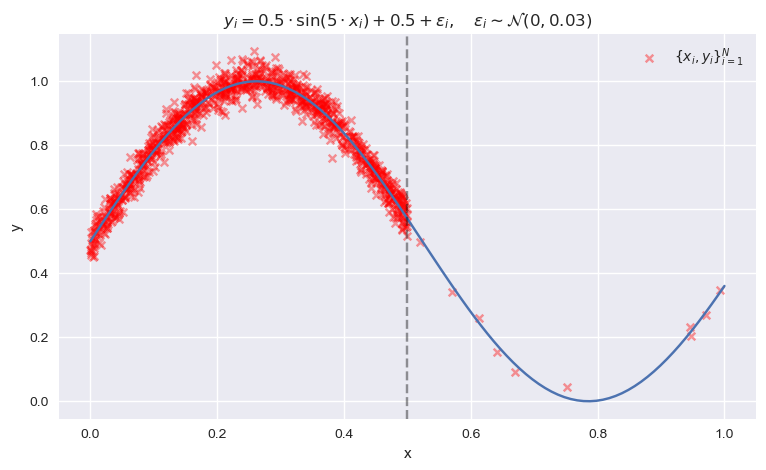

In [3]:
fig, ax = plt.subplots(figsize=(9,5))
x_inst = dataset_eval.x_inst
y_targets = dataset_eval.y_targets

# plot function which generates targets
x = np.linspace(0,1,100)
y = sine_fct_prediction(x, freq=dataset_eval.sine_factor)

ax.set_xlabel("x")
ax.set_ylabel("y")


plt.plot(x,y)
plt.scatter(x_inst, y_targets, s=30, marker="x", color="red", alpha=0.4, label="$\{x_i, y_i\}_{i=1}^N$")
plt.legend()
# make vertical line at x=split
plt.axvline(x=dataset_eval.split, color="black", linestyle="--", alpha=0.4)

plt.title("$y_i = 0.5 \cdot \sin(5 \cdot x_i) + 0.5 + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, 0.03)$")

### Train the First Order Predictor Ensemble

In [4]:
# test: train an ensemble of primary models with Negative Log Likelihood
ensemble_primary = GaussianEnsemble(
    model_config=model_config["Normal"], ensemble_size=train_config["Normal"]["n_runs"]
)
ensemble_primary.train(
    dataset=SineRegressionDataset,
    data_params=data_config["SineRegression"],
    train_params=train_config["Normal"],)

plot losses:

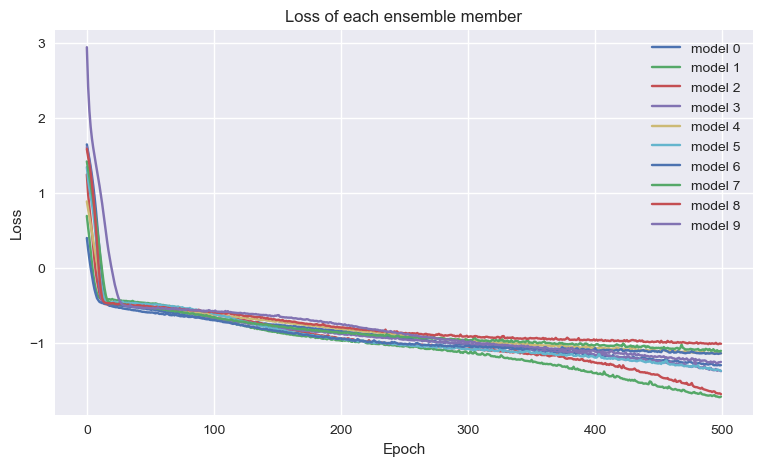

In [5]:
losses = ensemble_primary.losses
losses = np.stack(losses, axis=0)

# plot loss of each ensemble member
fig, ax = plt.subplots(figsize=(9,5))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss of each ensemble member")
for i in range(losses.shape[0]):
    ax.plot(losses[i,:], label=f"model {i}")
ax.legend()


make predictions:

In [7]:
x_eval = torch.from_numpy(np.linspace(0,1,1000)).float()

In [6]:
preds = ensemble_primary.predict(x_eval.view(-1,1))

In [7]:
pred_means, pred_stds = ensemble_primary.predict_mean_var(x_eval.view(-1,1))

sample target values from the mean and std

In [8]:
y_targets_pred = torch.normal(mean=pred_means, std=pred_stds).detach().numpy().flatten()

calculate prediction intervals using the 95 % confidence interval:

In [9]:
lower, upper = get_upper_lower_bounds(p=0.975, mu=pred_means.detach().numpy(), sigma=pred_stds.detach().numpy())

plot results:

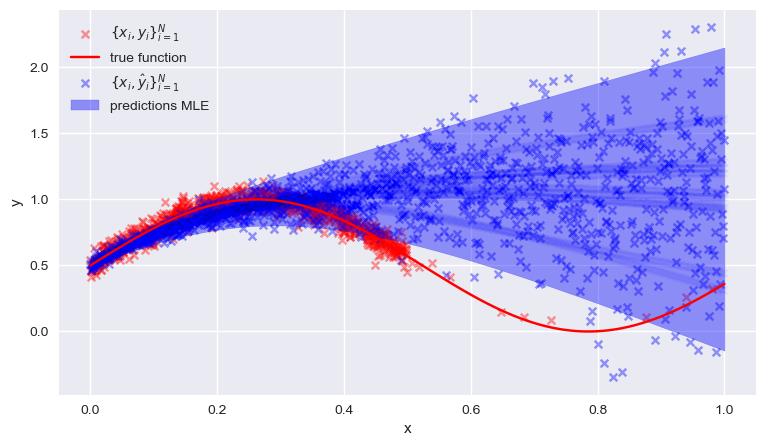

In [10]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(x_inst, y_targets, s=30, marker="x", color="red", alpha=0.4, label="$\{x_i, y_i\}_{i=1}^N$")
plt.plot(x,y, color="red", label="true function")
ax.scatter(x_eval.numpy(), y_targets_pred, s=30, marker="x", color="blue", alpha=0.4, label="$\{x_i, \hat{y}_i\}_{i=1}^N$")
ax.fill_between(x_eval, lower, upper, color="blue",
 alpha=0.4, label="predictions MLE")
for i in range(ensemble_primary.ensemble_size):
    ax.scatter(x_eval.numpy(), preds[:,i,0].detach().numpy(), s=30, marker="x", color="blue", alpha=0.01)
plt.legend()

### Train with secondary loss optimisation

#### 1. Without Regularization

In [11]:
ensemble_secondary_inner = Ensemble(model_config=model_config["NormalInverseGamma"], ensemble_size=10)
ensemble_secondary_outer = Ensemble(model_config=model_config["NormalInverseGamma"], ensemble_size=10)

In [12]:
ensemble_secondary_inner.train(dataset=SineRegressionDataset, data_params=data_config["SineRegression"], train_params=train_config["NIG_inner"])

In [13]:
ensemble_secondary_outer.train(dataset=SineRegressionDataset, data_params=data_config["SineRegression"], train_params=train_config["NIG_outer"])

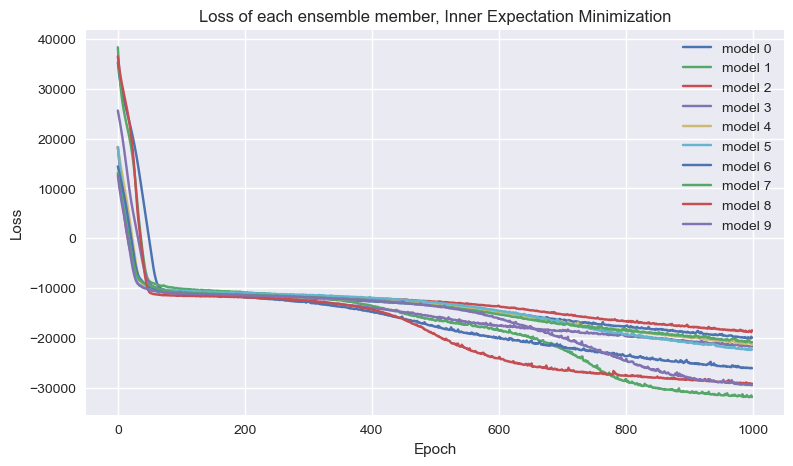

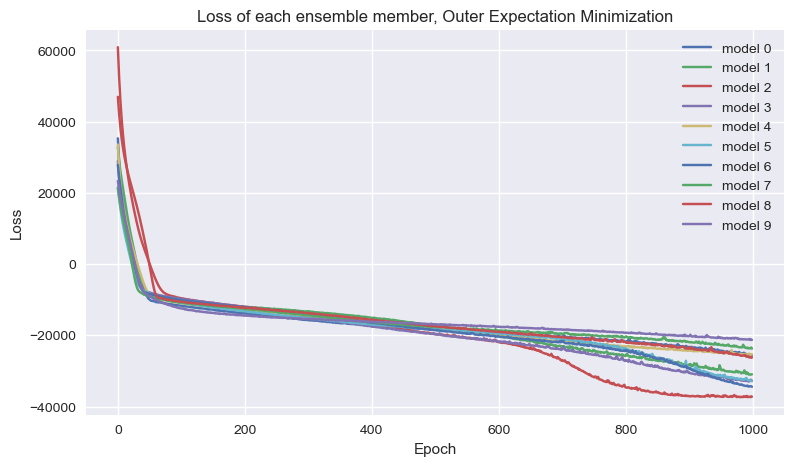

In [16]:
# plot losses

losses_inner = ensemble_secondary_inner.losses
losses_outer = ensemble_secondary_outer.losses

losses_inner = np.stack(losses_inner, axis=0)
losses_outer = np.stack(losses_outer, axis=0)

fig, ax = plt.subplots(figsize=(9,5))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss of each ensemble member, Inner Expectation Minimization")
for i in range(losses_inner.shape[0]):
    # plot log of loss
    ax.plot(losses_inner[i,:], label=f"model {i}")
    #ax.plot(losses_inner[i,:], label=f"model {i}")  
ax.legend()

fig, ax = plt.subplots(figsize=(9,5))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss of each ensemble member, Outer Expectation Minimization")
for i in range(losses_outer.shape[0]):
    ax.plot(losses_outer[i,:], label=f"model {i}")
ax.legend()



calculate mean predictions of the parameters of the NIG distribution

In [17]:
mean_preds_inner = ensemble_secondary_inner.predict_mean(x_eval.view(-1,1))
mean_preds_outer = ensemble_secondary_outer.predict_mean(x_eval.view(-1,1))

preds_inner = ensemble_secondary_inner.predict(x_eval.view(-1,1))


In [40]:
pred_gamma_inner = mean_preds_inner[:, 0]
pred_gamma_outer = mean_preds_outer[:, 0]

pred_var_inner = mean_preds_inner[:, 3]/(mean_preds_inner[:, 1]*(mean_preds_inner[:,2] -1))
pred_al_inner = pred_var_inner*mean_preds_inner[:, 1]

pred_var_outer = mean_preds_outer[:, 3]/(mean_preds_outer[:, 1]*(mean_preds_outer[:,2] -1))
pred_al_outer = pred_var_outer*mean_preds_outer[:, 1]


In [41]:
# get lower and upper bounds for predicted normal distribution
lower_inner_ep, upper_inner_ep = get_upper_lower_bounds(p=0.975, mu = pred_gamma_inner.detach().numpy(), sigma = pred_var_inner.detach().numpy())
lower_inner_al, upper_inner_al = get_upper_lower_bounds(p=0.975, mu = pred_gamma_inner.detach().numpy(), sigma = pred_al_inner.detach().numpy())

# get lower and upper bounds for predicted normal distribution for outer+
lower_outer_ep, upper_outer_ep = get_upper_lower_bounds(p=0.975, mu = pred_gamma_outer.detach().numpy(), sigma = pred_var_outer.detach().numpy())
lower_outer_al, upper_outer_al = get_upper_lower_bounds(p=0.975, mu = pred_gamma_outer.detach().numpy(), sigma = pred_al_outer.detach().numpy())


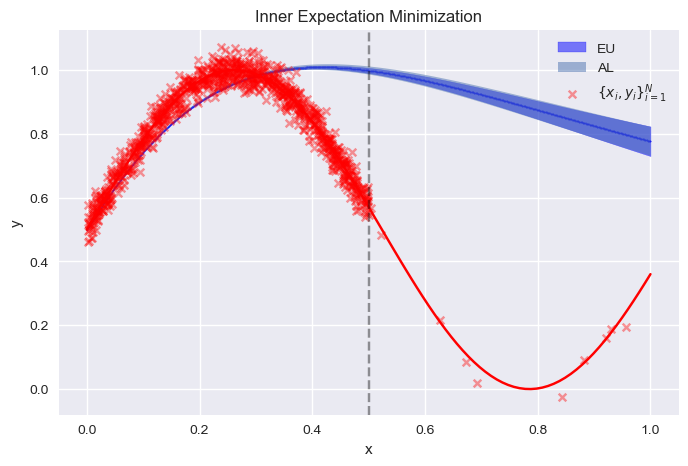

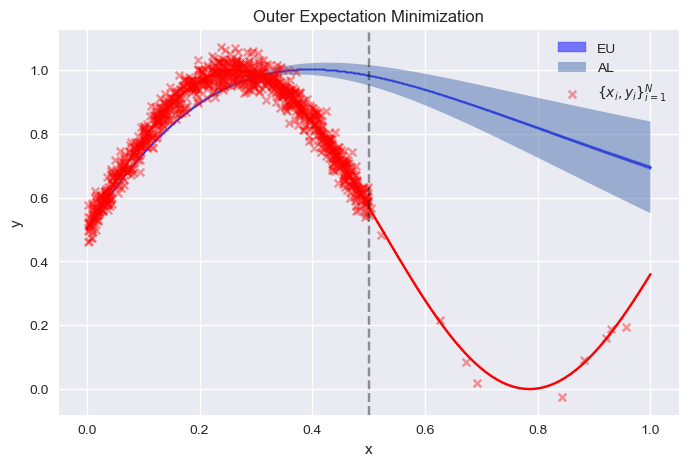

In [44]:
# plot results
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x_eval, pred_gamma_inner.detach().squeeze(), s=1, color="blue", alpha=0.5)
ax.fill_between(x_eval, lower_inner_ep, upper_inner_ep, color="blue",
    alpha=0.5, label="EU")
ax.fill_between(x_eval, lower_inner_al, upper_inner_al,
    alpha=0.5, label="AL")
#ax.fill_between(x_eval, lower_bound_al.detach().squeeze(), upper_bound_al.detach().squeeze(),
 #   alpha=0.5, label="AL")

plt.plot(x,y, color="red")
ax.scatter(x_inst, y_targets, s=30, marker="x", color="red", alpha=0.4, label="$\{x_i, y_i\}_{i=1}^N$")
plt.axvline(x=dataset_eval.split, color="black", linestyle="--", alpha=0.4)
# scatter plot instances and targets from the dataset

ax.set_xlabel("x")
ax.set_ylabel("y")
plt.title("Inner Expectation Minimization")
plt.legend()

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x_eval, pred_gamma_outer.detach().squeeze(), s=1, color="blue", alpha=0.5)
ax.fill_between(x_eval, lower_outer_ep, upper_outer_ep, color="blue",
    alpha=0.5, label="EU")
ax.fill_between(x_eval, lower_outer_al, upper_outer_al,
    alpha=0.5, label="AL")
plt.plot(x,y, color="red")
ax.scatter(x_inst, y_targets, s=30, marker="x", color="red", alpha=0.4, label="$\{x_i, y_i\}_{i=1}^N$")
plt.axvline(x=dataset_eval.split, color="black", linestyle="--", alpha=0.4)

ax.set_xlabel("x")
ax.set_ylabel("y")
plt.title("Outer Expectation Minimization")
plt.legend()


#### 2. With Regularization

In [4]:
ensemble_secondary_inner_reg = NIGEnsemble(model_config=model_config["NormalInverseGamma"], ensemble_size=10)
ensemble_secondary_outer_reg = NIGEnsemble(model_config=model_config["NormalInverseGamma"], ensemble_size=10)


In [5]:
ensemble_secondary_inner_reg.train(dataset=SineRegressionDataset, data_params=data_config["SineRegression"],
                                    train_params=train_config["NIG_inner_reg"])

In [6]:
ensemble_secondary_outer_reg.train(dataset=SineRegressionDataset, data_params=data_config["SineRegression"],
                                    train_params=train_config["NIG_outer_reg"])

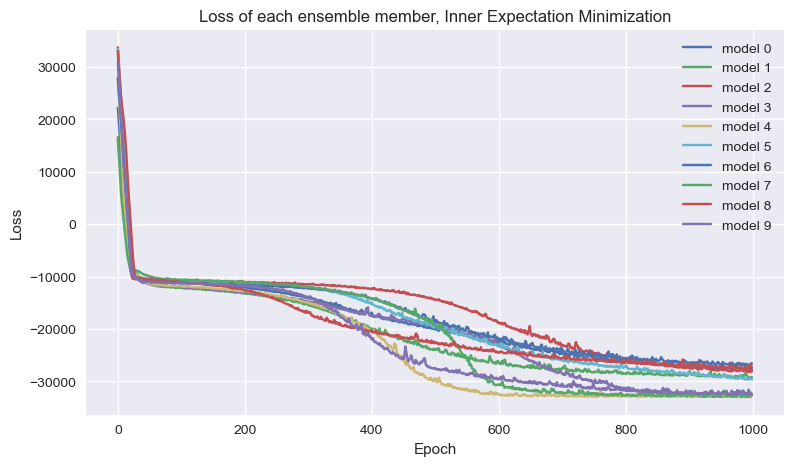

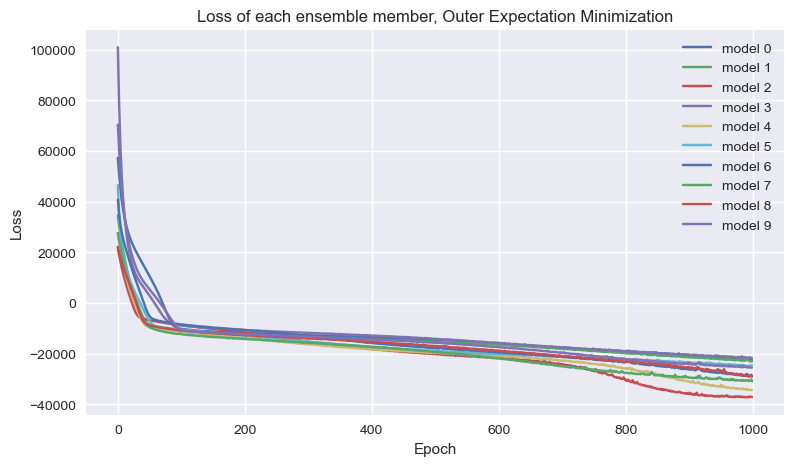

In [10]:
# plot losses

losses_inner = ensemble_secondary_inner_reg.losses
losses_outer = ensemble_secondary_outer_reg.losses

losses_inner = np.stack(losses_inner, axis=0)
losses_outer = np.stack(losses_outer, axis=0)

fig, ax = plt.subplots(figsize=(9,5))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss of each ensemble member, Inner Expectation Minimization")
for i in range(losses_inner.shape[0]):
    # plot log of loss
    ax.plot(losses_inner[i,:], label=f"model {i}")
    #ax.plot(losses_inner[i,:], label=f"model {i}")  
ax.legend()

fig, ax = plt.subplots(figsize=(9,5))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss of each ensemble member, Outer Expectation Minimization")
for i in range(losses_outer.shape[0]):
    ax.plot(losses_outer[i,:], label=f"model {i}")
ax.legend()


In [27]:
pred_mu_inner_reg, pred_std_inner_reg = ensemble_secondary_inner_reg.predict_normal_params(x_eval.view(-1,1))
pred_mu_outer_reg, pred_std_outer_reg = ensemble_secondary_outer_reg.predict_normal_params(x_eval.view(-1,1))

pred_ep_inner_reg, pred_al_inner_reg = ensemble_secondary_inner_reg.predict_uc(x_eval.view(-1,1))
pred_ep_outer_reg, pred_al_outer_reg = ensemble_secondary_outer_reg.predict_uc(x_eval.view(-1,1))

# lower and upper bounds for predicted normal distribution
lower_inner_reg_ep, upper_inner_reg_ep = get_upper_lower_bounds(p=0.975, mu = pred_mu_inner_reg.detach().numpy(), sigma = np.sqrt(pred_ep_inner_reg.detach().numpy()))
lower_inner_reg_al, upper_inner_reg_al = get_upper_lower_bounds(p=0.975, mu = pred_mu_inner_reg.detach().numpy(), sigma = pred_std_inner_reg.detach().numpy())

# lower and upper bounds for predicted normal distribution, outer
lower_outer_reg_ep, upper_outer_reg_ep = get_upper_lower_bounds(p=0.975, mu = pred_mu_outer_reg.detach().numpy(), sigma = np.sqrt(pred_ep_outer_reg.detach().numpy()))
lower_outer_reg_al, upper_outer_reg_al = get_upper_lower_bounds(p=0.975, mu = pred_mu_outer_reg.detach().numpy(), sigma = pred_std_outer_reg.detach().numpy())

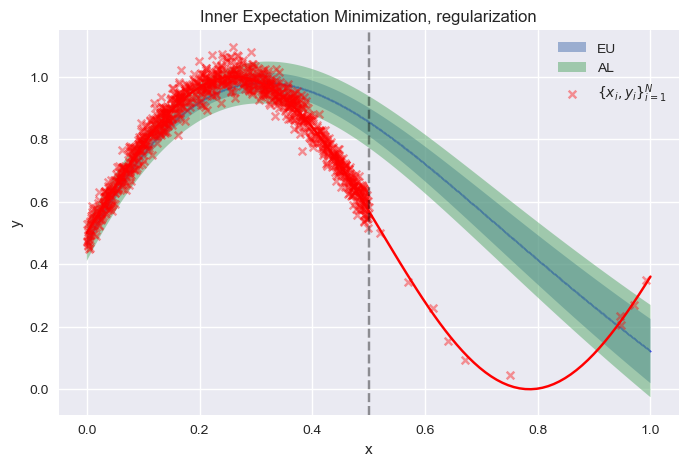

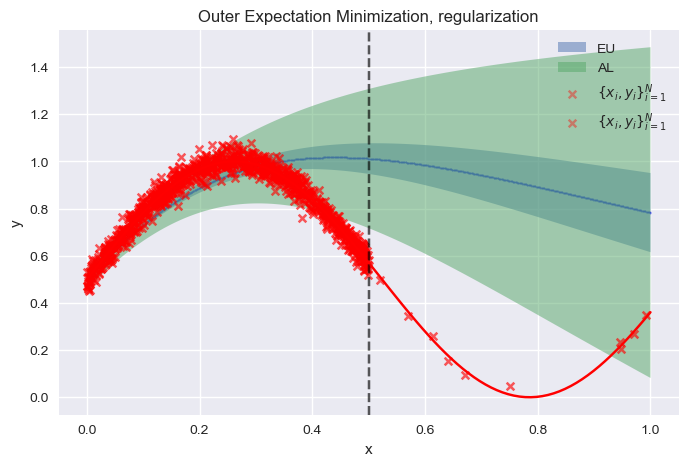

In [34]:
# plot results
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(x_eval, pred_mu_inner_reg.detach().squeeze(), s=1, color="blue", alpha=0.5)
ax.fill_between(x_eval, lower_inner_reg_ep, upper_inner_reg_ep,
    alpha=0.5, label="EU")
ax.fill_between(x_eval, lower_inner_reg_al, upper_inner_reg_al,
    alpha=0.5, label="AL")

plt.plot(x,y, color="red")
# scatter plot instances and targets from the dataset
ax.scatter(x_inst, y_targets, s=30, marker="x", color="red", alpha=0.4, label="$\{x_i, y_i\}_{i=1}^N$")
plt.axvline(x=dataset_eval.split, color="black", linestyle="--", alpha=0.4)

ax.set_xlabel("x")
ax.set_ylabel("y")
plt.legend()
plt.title(f"Inner Expectation Minimization, regularization")

fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(x_eval, pred_mu_outer_reg.detach().squeeze(), s=1, color="blue", alpha=0.5)
ax.fill_between(x_eval, lower_outer_reg_ep, upper_outer_reg_ep,
    alpha=0.5, label="EU")
ax.fill_between(x_eval, lower_outer_reg_al, upper_outer_reg_al,
    alpha=0.5, label="AL")

ax.scatter(x_inst, y_targets, s=30, marker="x", color="red", alpha=0.4, label="$\{x_i, y_i\}_{i=1}^N$")
plt.axvline(x=dataset_eval.split, color="black", linestyle="--", alpha=0.4)
# scatter plot instances and targets from the dataset
ax.scatter(x_inst, y_targets, s=30, marker="x", color="red", alpha=0.4, label="$\{x_i, y_i\}_{i=1}^N$")
plt.plot(x,y, color="red")
plt.axvline(x=dataset_eval.split, color="black", linestyle="--", alpha=0.4)

ax.set_xlabel("x")
ax.set_ylabel("y")
plt.title(f"Outer Expectation Minimization, regularization")
plt.legend()


#### 2. Outer Expectation Minimization:

In [44]:
model = NIGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataset = SineRegressionDataset(n_samples=N_SAMPLES, x_max=0.5, n_samples_2=10, eps_var=0.01)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
model_out = train_model(model, dataloader=dataloader, criterion=loss_secondary_outer_reg, n_epochs=N_EPOCHS, optim=optimizer)

In [46]:
gamma, nu, alpha, beta = model_out(torch.from_numpy(x_eval).reshape(-1, 1).float())
pred = gamma
epistemic_uc = beta/(nu*(alpha-1))
aleatoric_uc = beta/(alpha - 1)

# caluclate upper and lower bounds for the prediction using the epistemic uncertainty
lower_bound = pred - epistemic_uc
upper_bound = pred + epistemic_uc

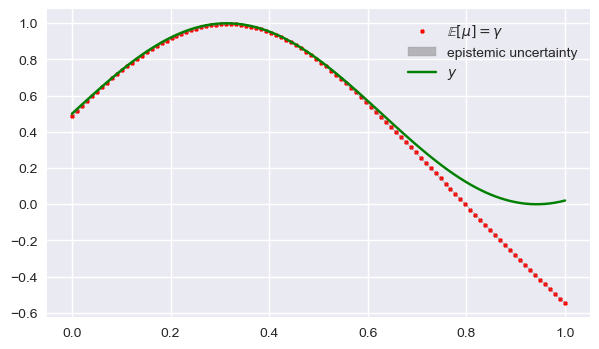

In [47]:
fig, ax = plt.subplots(figsize=(7,4))

ax.scatter(x_eval, pred.detach().numpy().squeeze(), s=5, marker="x", color="red", alpha=1, label="$\mathbb{E}[\mu] = \gamma $")
plt.fill_between(x_eval, lower_bound.detach().numpy().squeeze(), upper_bound.detach().numpy().squeeze(), color='gray', alpha=0.5, 
                label="epistemic uncertainty")
plt.plot(x,y, color="green", label="$y$")
plt.legend()

#### Train Ensemble of Secondary Predictors

#### 1. outer loss without regularization

In [70]:
# evaluate model on evaluation data
x_eval = np.array(np.linspace(0, 1, 100))

# dataset: high variance in targets
dataset = SineRegressionDataset(n_samples_1=200, x_max=0.4, n_samples_2=50, eps_var=0.005)

#gamma, nu, alpha, beta = model_out(torch.from_numpy(x_eval).reshape(-1, 1).float())


ensemble_primary = Ensemble(
    model_config=model_config["NormalInverseGamma"], ensemble_size=train_config["NIG_outer"]["n_runs"]
)
ensemble_primary.train(
    dataset=SineRegressionDataset,
    n_samples_1=N_SAMPLES,
    n_samples_2=N_SAMPLES_OUT,
    x_split=0.5,
    eps_var=0.03,
    train_params=train_config["NIG_outer"],)

In [72]:
results_gamma = np.zeros((ensemble_primary.ensemble_size, x_eval.shape[0]))
results_nu = np.zeros((ensemble_primary.ensemble_size, x_eval.shape[0]))
results_alpha = np.zeros((ensemble_primary.ensemble_size, x_eval.shape[0]))
results_beta = np.zeros((ensemble_primary.ensemble_size, x_eval.shape[0]))


sorted_x_inst = torch.sort(dataset_eval.x_inst)[0].view(-1,1)
y_sorted = dataset_eval.y_targets[torch.argsort(dataset_eval.x_inst)]
for i, model in enumerate(ensemble_primary.models):

    # make prediuctions on sorted x_inst
    gamma, nu, alpha, beta = model(torch.from_numpy(x_eval).reshape(-1, 1).float())

    results_gamma[i, :] = gamma.detach().numpy().squeeze()
    results_nu[i,:] = nu.detach().numpy().squeeze()
    results_alpha[i,:] = alpha.detach().numpy().squeeze()
    results_beta[i, :] = beta.detach().numpy().squeeze()    

# calculate average


In [77]:
pred = np.mean(results_gamma, axis=0)
epistemic_uc = np.mean(results_beta, axis=0) / (
    np.mean(results_nu, axis=0) * (np.mean(results_alpha, axis=0) - 1)
)
aleatoric_uc = np.mean(results_beta, axis=0) / (np.mean(results_alpha, axis=0)- 1)

# caluclate upper and lower bounds for the prediction using the epistemic uncertainty
lower_bound = pred - aleatoric_uc
upper_bound = pred + aleatoric_uc

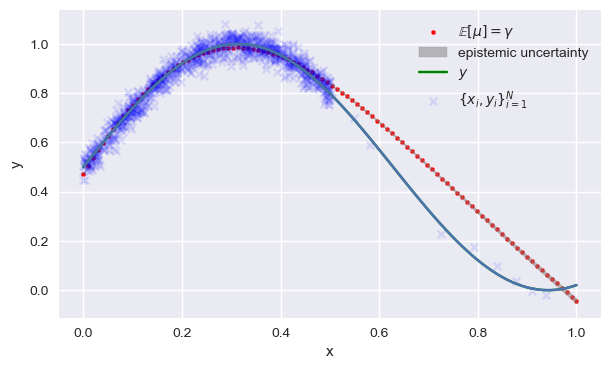

In [80]:
fig, ax = plt.subplots(figsize=(7,4))

ax.scatter(x_eval, pred.squeeze(), s=5, marker="x", color="red", alpha=1, label="$\mathbb{E}[\mu] = \gamma $")
plt.fill_between(x_eval, lower_bound.squeeze(), upper_bound.squeeze(), color='gray', alpha=0.5, 
                label="epistemic uncertainty")
plt.plot(x,y, color="green", label="$y$")
# plot real targets
x_inst = dataset_eval.x_inst
y_targets = dataset_eval.y_targets

ax.set_xlabel("x")
ax.set_ylabel("y")


plt.plot(x,y)
plt.scatter(x_inst, y_targets, s=30, marker="x", color="blue", alpha=0.1, label="$\{x_i, y_i\}_{i=1}^N$")
plt.legend()

### 2. outer loss with regularization

In [82]:
# evaluate model on evaluation data
x_eval = np.array(np.linspace(0, 1, 100))

# dataset: high variance in targets
dataset = SineRegressionDataset(n_samples_1=200, x_max=0.4, n_samples_2=50, eps_var=0.005)

#gamma, nu, alpha, beta = model_out(torch.from_numpy(x_eval).reshape(-1, 1).float())


ensemble_secondary_reg = Ensemble(
    model_config=model_config["NormalInverseGamma"], ensemble_size=train_config["NIG_outer_reg"]["n_runs"]
)
ensemble_secondary_reg.train(
    dataset=SineRegressionDataset,
    n_samples_1=N_SAMPLES,
    n_samples_2=N_SAMPLES_OUT,
    x_split=0.5,
    eps_var=0.03,
    train_params=train_config["NIG_outer_reg"],)

In [83]:
results_gamma = np.zeros((ensemble_secondary_reg.ensemble_size, x_eval.shape[0]))
results_nu = np.zeros((ensemble_secondary_reg.ensemble_size, x_eval.shape[0]))
results_alpha = np.zeros((ensemble_secondary_reg.ensemble_size, x_eval.shape[0]))
results_beta = np.zeros((ensemble_secondary_reg.ensemble_size, x_eval.shape[0]))


sorted_x_inst = torch.sort(dataset_eval.x_inst)[0].view(-1,1)
y_sorted = dataset_eval.y_targets[torch.argsort(dataset_eval.x_inst)]
for i, model in enumerate(ensemble_secondary_reg.models):

    # make prediuctions on sorted x_inst
    gamma, nu, alpha, beta = model(torch.from_numpy(x_eval).reshape(-1, 1).float())

    results_gamma[i, :] = gamma.detach().numpy().squeeze()
    results_nu[i,:] = nu.detach().numpy().squeeze()
    results_alpha[i,:] = alpha.detach().numpy().squeeze()
    results_beta[i, :] = beta.detach().numpy().squeeze()    

# calculate average

In [86]:
pred = np.mean(results_gamma, axis=0)
epistemic_uc = np.mean(results_beta, axis=0) / (
    np.mean(results_nu, axis=0) * (np.mean(results_alpha, axis=0) - 1)
)
aleatoric_uc = np.mean(results_beta, axis=0) / (np.mean(results_alpha, axis=0)- 1)

# caluclate upper and lower bounds for the prediction using the epistemic uncertainty
lower_bound = pred - epistemic_uc
upper_bound = pred + epistemic_uc

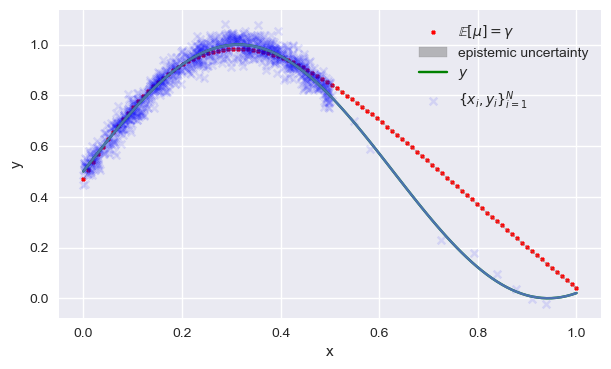

In [87]:
fig, ax = plt.subplots(figsize=(7,4))

ax.scatter(x_eval, pred.squeeze(), s=5, marker="x", color="red", alpha=1, label="$\mathbb{E}[\mu] = \gamma $")
plt.fill_between(x_eval, lower_bound.squeeze(), upper_bound.squeeze(), color='gray', alpha=0.5, 
                label="epistemic uncertainty")
plt.plot(x,y, color="green", label="$y$")
# plot real targets
x_inst = dataset_eval.x_inst
y_targets = dataset_eval.y_targets

ax.set_xlabel("x")
ax.set_ylabel("y")


plt.plot(x,y)
plt.scatter(x_inst, y_targets, s=30, marker="x", color="blue", alpha=0.1, label="$\{x_i, y_i\}_{i=1}^N$")
plt.legend()

#### inner loss

In [89]:
# evaluate model on evaluation data
x_eval = np.array(np.linspace(0, 1, 100))

# dataset: high variance in targets
dataset = SineRegressionDataset(n_samples_1=200, x_max=0.4, n_samples_2=50, eps_var=0.005)

#gamma, nu, alpha, beta = model_out(torch.from_numpy(x_eval).reshape(-1, 1).float())


ensemble_secondary_reg = Ensemble(
    model_config=model_config["NormalInverseGamma"], ensemble_size=train_config["NIG_inner"]["n_runs"]
)
ensemble_secondary_reg.train(
    dataset=SineRegressionDataset,
    n_samples_1=N_SAMPLES,
    n_samples_2=N_SAMPLES_OUT,
    x_split=0.5,
    eps_var=0.03,
    train_params=train_config["NIG_inner"],)

In [90]:
results_gamma = np.zeros((ensemble_secondary_reg.ensemble_size, x_eval.shape[0]))
results_nu = np.zeros((ensemble_secondary_reg.ensemble_size, x_eval.shape[0]))
results_alpha = np.zeros((ensemble_secondary_reg.ensemble_size, x_eval.shape[0]))
results_beta = np.zeros((ensemble_secondary_reg.ensemble_size, x_eval.shape[0]))


sorted_x_inst = torch.sort(dataset_eval.x_inst)[0].view(-1,1)
y_sorted = dataset_eval.y_targets[torch.argsort(dataset_eval.x_inst)]
for i, model in enumerate(ensemble_secondary_reg.models):

    # make prediuctions on sorted x_inst
    gamma, nu, alpha, beta = model(torch.from_numpy(x_eval).reshape(-1, 1).float())

    results_gamma[i, :] = gamma.detach().numpy().squeeze()
    results_nu[i,:] = nu.detach().numpy().squeeze()
    results_alpha[i,:] = alpha.detach().numpy().squeeze()
    results_beta[i, :] = beta.detach().numpy().squeeze()    

# calculate average

In [93]:
pred = np.mean(results_gamma, axis=0)
epistemic_uc = np.mean(results_beta, axis=0) / (
    np.mean(results_nu, axis=0) * (np.mean(results_alpha, axis=0) - 1)
)
aleatoric_uc = np.mean(results_beta, axis=0) / (np.mean(results_alpha, axis=0)- 1)

# caluclate upper and lower bounds for the prediction using the epistemic uncertainty
lower_bound = pred - aleatoric_uc
upper_bound = pred + aleatoric_uc

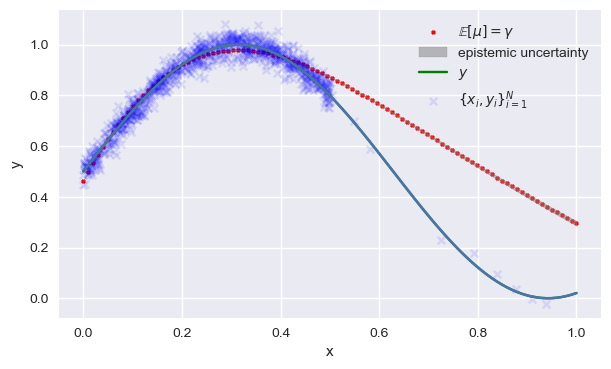

In [94]:
fig, ax = plt.subplots(figsize=(7,4))

ax.scatter(x_eval, pred.squeeze(), s=5, marker="x", color="red", alpha=1, label="$\mathbb{E}[\mu] = \gamma $")
plt.fill_between(x_eval, lower_bound.squeeze(), upper_bound.squeeze(), color='gray', alpha=0.5, 
                label="epistemic uncertainty")
plt.plot(x,y, color="green", label="$y$")
# plot real targets
x_inst = dataset_eval.x_inst
y_targets = dataset_eval.y_targets

ax.set_xlabel("x")
ax.set_ylabel("y")


plt.plot(x,y)
plt.scatter(x_inst, y_targets, s=30, marker="x", color="blue", alpha=0.1, label="$\{x_i, y_i\}_{i=1}^N$")
plt.legend()

In [4]:
# evaluate model on evaluation data
x_eval = np.array(np.linspace(0, 1, 100))

# dataset: high variance in targets
dataset = SineRegressionDataset(n_samples_1=200, x_max=0.4, n_samples_2=50, eps_var=0.005)

#gamma, nu, alpha, beta = model_out(torch.from_numpy(x_eval).reshape(-1, 1).float())


ensemble_secondary_reg = Ensemble(
    model_config=model_config["NormalInverseGamma"], ensemble_size=train_config["NIG_inner_reg"]["n_runs"]
)
ensemble_secondary_reg.train(
    dataset=SineRegressionDataset,
    n_samples_1=N_SAMPLES,
    n_samples_2=N_SAMPLES_OUT,
    x_split=0.5,
    eps_var=0.03,
    train_params=train_config["NIG_inner_reg"],)

In [5]:
results_gamma = np.zeros((ensemble_secondary_reg.ensemble_size, x_eval.shape[0]))
results_nu = np.zeros((ensemble_secondary_reg.ensemble_size, x_eval.shape[0]))
results_alpha = np.zeros((ensemble_secondary_reg.ensemble_size, x_eval.shape[0]))
results_beta = np.zeros((ensemble_secondary_reg.ensemble_size, x_eval.shape[0]))


sorted_x_inst = torch.sort(dataset_eval.x_inst)[0].view(-1,1)
y_sorted = dataset_eval.y_targets[torch.argsort(dataset_eval.x_inst)]
for i, model in enumerate(ensemble_secondary_reg.models):

    # make prediuctions on sorted x_inst
    gamma, nu, alpha, beta = model(torch.from_numpy(x_eval).reshape(-1, 1).float())

    results_gamma[i, :] = gamma.detach().numpy().squeeze()
    results_nu[i,:] = nu.detach().numpy().squeeze()
    results_alpha[i,:] = alpha.detach().numpy().squeeze()
    results_beta[i, :] = beta.detach().numpy().squeeze()    

# calculate average

In [6]:
pred = np.mean(results_gamma, axis=0)
epistemic_uc = np.mean(results_beta, axis=0) / (
    np.mean(results_nu, axis=0) * (np.mean(results_alpha, axis=0) - 1)
)
aleatoric_uc = np.mean(results_beta, axis=0) / (np.mean(results_alpha, axis=0)- 1)

# caluclate upper and lower bounds for the prediction using the epistemic uncertainty
lower_bound = pred - aleatoric_uc
upper_bound = pred + aleatoric_uc

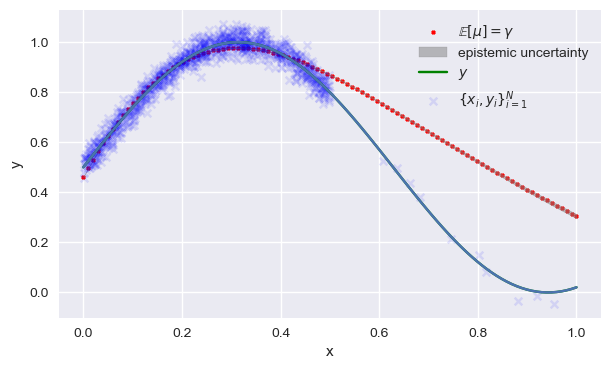

In [9]:
fig, ax = plt.subplots(figsize=(7,4))

ax.scatter(x_eval, pred.squeeze(), s=5, marker="x", color="red", alpha=1, label="$\mathbb{E}[\mu] = \gamma $")
plt.fill_between(x_eval, lower_bound.squeeze(), upper_bound.squeeze(), color='gray', alpha=0.5, 
                label="epistemic uncertainty")
plt.plot(x,y, color="green", label="$y$")
# plot real targets
x_inst = dataset_eval.x_inst
y_targets = dataset_eval.y_targets

ax.set_xlabel("x")
ax.set_ylabel("y")


plt.plot(x,y)
plt.scatter(x_inst, y_targets, s=30, marker="x", color="blue", alpha=0.1, label="$\{x_i, y_i\}_{i=1}^N$")
plt.legend()